# Regressão Logística e RNA para classificação

**Autor:** Felipe Maia Polo - Fundador e ex-presidente do Neuron - *Data science and Artificial Intelligence*, economista pela USP e mestrando em Estatística pela mesma instituição. Apaixonado por matemática, estatística e *data science*.

**Contato:** felipemaiapolo@gmail.com - https://www.linkedin.com/in/felipemaiapolo/

**Feedback:** https://forms.gle/U6yBVSYwxNRWaE15A

**Sugestões de leitura**

1. **Probabilidade:** Ross, S. (2014). A first course in probability. Pearson.
2. **Probabilidade e Estatística:** Morettin, P. A., & BUSSAB, W. O. (2017). Estatística básica. Editora Saraiva.
3. **Análise de Regressão (linear & logística):** Wooldridge, J. M. (2015). Introductory econometrics: A modern approach. Nelson Education.
4. **Machine Learning:** James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.

Antes de começarmos a falar da técnica de regressão logística é necessário apresentar a base de dados que vamos utilizar a partir de agora. A base de dados utilizada foi retirada do Kaggle no link: https://www.kaggle.com/joniarroba/noshowappointments. Esta é uma base brasileira de consultas médicas que foram agendadas no SUS de Vitória-ES. Cada observação da base de dados traz consigo dados do paciente, do agendamento e uma variável indicadora (0 ou 1) que nos diz se o paciente faltou ou não à consulta. Esta base é interessante, pois nos traz um caso real que nos permite entender melhor porque as pessoas faltam às consultas e nos ajuda a antecipar situações de falta para melhor gerenciamento do sistema como um todo. Apesar do nosso exemplo ser um caso específico da relação prestador de serviços e clientes, a metodologia que discutiremos a seguir pode ser utilizada em muitos outros casos.
A descrição das variáveis de acordo com o Kaggle é:

**PatientId**: Id dos pacientes

**Gender**: gênero do paciente 

**DataMarcacaoConsulta**: dia consulta 

**DataAgendamento**: dia do agendamento

**Age**: idade do paciente

**Neighbourhood**: vizinhança onde a consulta foi marcada

**Scholarship**: bolsa família

**Hipertension**: tem ou não hipertensão

**Diabetes**: tem ou não diabetes

**Alcoholism**: tem ou não alcoolismo

**Handcap**: tem ou não debilidade física

**SMSreceived**: se foram ou não enviadas mensagens para o paciente, lembrando-o da consulta 

**No-show**: se foi ou não na consulta

Vamos dar uma explorada/preparada na base para começarmos os trabalhos!

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("KaggleV2-May-2016.csv")

Checando como os dados estão:

In [3]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Mudando como algumas variáveis estavam na base de dados original:

In [4]:
data.ScheduledDay = data.ScheduledDay.apply(np.datetime64) #Formatando para data
data.AppointmentDay = data.AppointmentDay.apply(np.datetime64) #Formatando para data
data['WaitTime'] = (data.AppointmentDay - data.ScheduledDay).dt.days+1 #Dias de espera
data['NoShow']= data['No-show'].apply(lambda x: 1 if x =="Yes" else 0) #1=não foi à consulta e 0=foi
data['Gender']= data['Gender'].apply(lambda x: 0 if x =="M" else 1) #1=Feminino e 0=Masculino
data['Dia'] = data.AppointmentDay.dt.weekday #0=segunda-feira e 6=domingo

Dando um describe na base para termos uma noção melhor de como estão distribuídas as variáveis:

In [5]:
data.describe()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitTime,NoShow,Dia
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,0.649977,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702,0.201933,1.858243
std,2.560949e+14,7.129575e+04,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996,0.401444,1.371672
min,3.921784e+04,5.030230e+06,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.173184e+13,5.680573e+06,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.000000
75%,9.439172e+13,5.725524e+06,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000,3.000000
max,9.999816e+14,5.790484e+06,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000,1.000000,5.000000


Percebemos que há três coisas estranhas com nossa base: (i) há pessoas com idades negativas, (ii) há pessoas que tem a variável "Handcap" (debilidade física) como sendo maior que 1 (na teoria era para ser 0 ou 1) e (iii) pacientes com tempo de espera negativo em dias. Vamos contar quantos indivíduos carregam esses problemas para então transformar seus valores em "missing":

In [6]:
#Primeiramente para a idade:
sum(data['Age']<0)

1

In [7]:
#Handcap
sum(data['Handcap']>1)

199

In [8]:
#Tempo de espera
sum(data['WaitTime']<0)

5

Mandando valores estranhos para missing:

In [9]:
data['Age']=np.where(data['Age']<0,np.nan,data['Age'])
data['Handcap']=np.where(data['Handcap']>1,np.nan,data['Handcap'])
data['WaitTime']=np.where(data['WaitTime']<0,np.nan,data['WaitTime'])

Transformando variáveis categóricas em dummies (variáveis binárias), começando pelo dia da semana:

In [10]:
d=pd.get_dummies(data["Dia"], dummy_na=True)
d=pd.DataFrame(d)  
d.columns=["Seg", "Ter","Qua", "Qui","Sex","Sab","Dia_nan"]

data=data.join(d)

Agora vamos binarizar a variável de vizinhança:

In [11]:
d=pd.get_dummies(data["Neighbourhood"], dummy_na=True)
d=pd.DataFrame(d)

names=list(d)
names[81]="Viz_nan"

d.columns=[names]
data=data.join(d)

Agora que já mexemos no que queríamos para deixar nossa base mais "trabalhável', vamos mexer com algumas tabelas que podem nos dar pistas do porquê as faltas. Nossa primeira hipótese é que pessoas com alguma debilidade física tendem a faltar mais. Vamos então olhar mais de perto a distribuição conjunta de faltas e debilidade física:

In [12]:
tab=pd.crosstab(data['Handcap'],data['NoShow'], normalize=True)
tab

NoShow,0,1
Handcap,,
0.0,0.782884,0.198608
1.0,0.015191,0.003317


É muito claro que a maioria das pessoas não tem debilidade alguma e isso acaba deixando a primeira linha da tabela muito densa, fazendo com que fique difícil avaliar a probabilidade de ir ou não à consulta condicionada ao fato de ter ou não debilidade física. Vamos então normalizar nas linhas, fazendo com que a soma por linha seja 1, para obtermos assim a probabilidade condicional que queremos:

In [13]:
tab=pd.crosstab(data['Handcap'],data['NoShow'], normalize= 'index')
tab

NoShow,0,1
Handcap,,
0.0,0.797647,0.202353
1.0,0.820764,0.179236


É possível ver uma diferença de mais ou menos 2,5p.p. na probabilidade de aparecer na consulta, o que invalida, a princípio, minha hipótese. Vamos agora checar como a variável gênero se relaciona com aparecer na consulta:

In [14]:
tab=pd.crosstab(data['Gender'],data['NoShow'], normalize= 'index')
tab

NoShow,0,1
Gender,,
0,0.800321,0.199679
1,0.796854,0.203146


É possível ver que parece não haver nenhuma relação entre Gênero e presença na consulta. Vamos ver a variável de SMS:

In [15]:
tab=pd.crosstab(data['SMS_received'],data['NoShow'], normalize= 'index')
tab

NoShow,0,1
SMS_received,,
0,0.832967,0.167033
1,0.724255,0.275745


Aconteceu aqui algo não intuitivo. Por que pessoas que receberam SMS para lembrá-las tem menos chances de ir à consulta? Pode ser que haja um viés de seleção, ou seja, eles enviam para pessoas com mais chances de faltar - um exemplo do porquê isso pode acontecer é que eles mandem SMS somente para pessoas que marcaram consultas em datas muito distantes (que são aquelas mais propensas a faltar). Vamos verificar se essa hipótese faz sentido abaixo - como a variável de dias de espera tem muitas opções de dias, vamos ver o resultado graficamente (lembre que estamos vendo as distribuições condicionais aos fatos de receber ou não SMS):

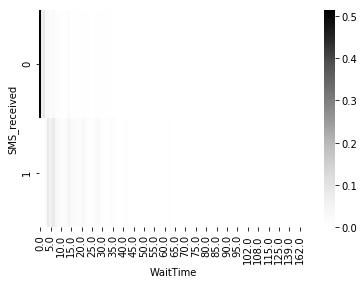

In [16]:
tab=pd.crosstab(data['SMS_received'],data['WaitTime'], normalize='index')

sns.heatmap(tab, cmap="Greys")
plt.show()

É possível ver que nossa hipótese se confirma: entre os que receberam SMS, nenhum deles estava muito próximo da consulta, e entre os que não receberam, uma grande parte estava próxima da consulta.

Vamos avaliar agora a relação entre a diferença de dias entre a consulta e o dia em que a consulta foi marcada, afim de validar essa outra hipótese:

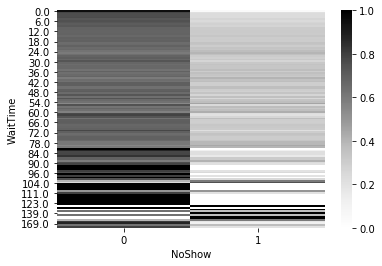

In [17]:
tab=pd.crosstab(data['WaitTime'],data['NoShow'], normalize='index')

sns.heatmap(tab, cmap="Greys")
plt.show()

Algumas coisas são notáveis do gráfico acima: (i) quando a pessoa marca no dia, muito provavelmente ela vai (até porque pode ser que o registro de agendamento seja feito na hora), (ii) nos primeiros 20 dias, há uma clara tendência em diminuir a probabilidade de ir à consulta, (iii) depois fica difícil pegar um padrão, talvez porque o número de consultas diminua muito e isso impacte na confiabilidade da estimação. Vamos agora trabalhar com a variável de idade. Como a variável de idade tem muitos valores, vamos trabalhar com o Heatmap, para dar uma noção mais geral dos fatos de forma rápida:

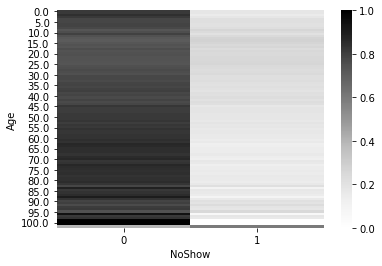

In [18]:
tab=pd.crosstab(data['Age'],data['NoShow'], normalize= 'index')

sns.heatmap(tab, cmap="Greys")
plt.show()

No gráfico acima, é possível ver que a idade pode ter alguma influência na probabilidade de aparecer ou não na consulta. O que nos parece é que até certa idade, os anos estão relacionados positivamente com não aparecer na consulta e depois a relação passa a ser positiva - parece que temos uma relação quadrática. Até o momento avaliamos de forma descritiva o impacto de cada uma das variáveis na probabilidade de comparecer nas consultas. Agora vamos entrar um pouco a fundo na teoria de regressão logística, que nos permitirá estimar a influência de cada uma das variáveis na probabilidade de comparecer à consulta.

Vamos começar com uma motivação clássica envolvendo o modelo de Regressão Logística, que é conhecida como motivação da Variável Latente: imagine que $Y^*$ é uma variável que denota a desmotivação dos indivíduos em sair de casa para ir ao médico (cansaço, muitas tarefas etc) e, como não podemos mensurá-la diretamente, dizemos que é uma variável latente. Sabemos que a desmotivação em ir à consulta pode estar relacionada com uma variável $X$, que é a diferença de dias entre o dia do agendamento e o dia da consulta (um exemplo), além de estar relacionada a fatores não observados materializados na forma do termo aleatório $\epsilon$. Modelando a desmotivação como se fosse equação utilizada em regressão linear, teríamos:

\begin{equation}
 Y^*=b+w_1X+\epsilon
\end{equation}

Assuma também que em nossa base de dados temos 2 variáveis: (i) $Y$ - binária e que diz que se os indivíduos não foram à consulta (1) ou foram (0), (ii) $X$ que é a diferença de dias entre o dia do agendamento e o dia da consulta. Imagine que se a desmotivação dos indivíduos não chegam a um certo limiar, os indivíduos vão à consulta. Assumindo que o limiar seja zero temos para um indivíduo qualquer:

\begin{equation}
 Y=\begin{cases}
1 & \text{, se } Y^*=b+w_1X+\epsilon_j \geq 0 \\ 
0 & \text{, se } Y^*=b+w_1X+\epsilon_j<0 
\end{cases}
\end{equation}

É visível pela equação acima que o fato de um indivíduo ir ou não à consulta depende diretamente da desmotivação dele ultrapassar o limiar proposto - considere que $b~\text{e}~w_1$ são parâmetros a serem estimados e que $\epsilon$ é um erro aleatório que segue uma distribuição específica arbitrária (na teoria poderia ser uma distribuição Normal, Logística, Cauchy etc). Pela equação acima, chegamos ao fato que de a probabilidade de o indivíduo $j$ faltar na consulta é dada por:

\begin{equation}
P(Y=1 | X)=P(Y^* \geq 0| X)=P(b+w_1X+\epsilon \geq 0)=P(\epsilon \geq -b-w_1X)=P(\epsilon \geq -z)
\end{equation}

Se considerarmos que $\epsilon$ tem distribuição logística (https://en.wikipedia.org/wiki/Logistic_distribution) centrada e simétrica no zero (sigmoid) a probabilidade $P(Y=1 | X)$ iguala-se a:

\begin{equation}
P(Y=1 | X)=P(\epsilon \leq b+w_1X)=\frac{1}{1+e^{-(b+w_1X)}}=\frac{1}{1+e^{-z}}
\end{equation}

A última expressão da direita também é conhecida como Função Sigmoid, especialmente no ramo das Rede Neurais Artificiais - como já vimos. A Regressão Logística serve então para estimar a probabilidade condicional de um fato ocorrer dadas as outras variáveis, ou seja, a variável dependente neste caso é qualitativa, podendo assumir 0 ou 1. Além de estimar a probabilidade condicional da ocorrência de um evento, é possível verificar qual a influência de outras variáveis sobre a probabilidade do acontecimento do evento e também é possível prever o acontecimento do evento se arredondarmos a probabilidade estimada para 0 ou 1, de acordo com seu valor. Pelo fato de estarmos estimando uma composição de uma função linear, dizemos que a regressão logística é um classificador linear, ou seja, o modelo encontra os parâmetros que melhor traçam um hiperplano (um plano com várias dimensões) dividindo as classes, minimizando assim a função perda - neste caso não trabalhamos mais com o EQM mas com a Entropia Cruzada ou "Cross Entropy". Para mais detalhes a respeito dessa função, ver http://cs231n.github.io/linear-classify/. Vamos ver a cara da função Sigmoid (logística):

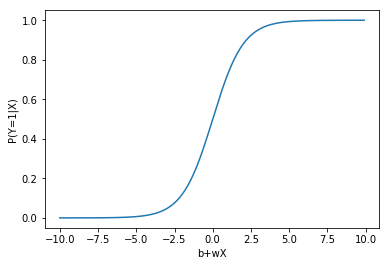

In [19]:
def sigmoid(z):
    return 1/(1+np.e**-z)

#Desenhando o gráfico da função
t = np.arange(-10, 10, 0.1)
plt.plot(t, sigmoid(t))
plt.xlabel("b+wX")
plt.ylabel("P(Y=1|X)")
plt.show()

É possível ver que, se para certo indivíduo, $z=b+w_1X$ é muito pequeno, então a probabilidade de ele ir à consulta é quase nula. Se $z=b+w_1X=0$, a probabilidade de ele ir à consulta é 0,5 e se $z=b+w_1X$ é muito grande, então a probabilidade de ele ir à consulta é quase 1. Então o nosso objetivo central é estimar os parâmetros $b$ e $w_1$, pois $X$ já temos em nossa base de dados. Perceba que $w$ é positivo se $Y$ tem relação positiva com $X$, $w$ é zero se não há relação entre as variáveis e $w$ é negativo se há uma relação negativa entre as variáveis. Observe que nas extremidades do eixo horizontal, variações em $X$ têm pouca influência sobre a probabilidade de $Y$ ser igual a 1, mas próximo ao $0$ do eixo horizontal, variações em $X$ têm grande influência na probabilidade de $Y$ ser igual a 1. Um fato importante é que $w_1$ não é muito interpretável, além da forma qualitativa (sinal), então vamos estimar o efeito de $X$ sobre a probabilidade de não ir à consulta - veja que já falamos que dependendo do nível de X, o efeito de X sobre a probabilidade de interesse varia. Dessa maneira, vamos fixar nossas atenções sobre a influência **média** de X sobre a probabilidade de interesse.

Agora que já temos uma noção da teoria, vamos partir para a estimação do efeito de $X$ em $Y$ com o pacote statsmodel:

In [20]:
import statsmodels.formula.api as smf

logit = smf.mnlogit('NoShow ~ WaitTime', data)
logit_res = logit.fit() #Estimando

Optimization terminated successfully.
         Current function value: 0.487882
         Iterations 5


Visualizando tabela com resultados, com efeito médio de X sobre a probabilidade de ir à consulta:

In [21]:
margeff0 = logit_res.get_margeff()
margeff0.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:                 NoShow
Method:                          dydx
At:                           overall
==============================================================================
  NoShow=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WaitTime      -0.0040    6.7e-05    -60.010      0.000      -0.004      -0.004
------------------------------------------------------------------------------
  NoShow=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WaitTime       0.0040    6.7e-05     60.010      0.000       0.004       0.004
==============================================================================
"""

Como nosso interesse é o efeito de $X$ sobre $P(Y=1|X)$, vamos olhar para a parte da tabela que diz "NoShow=1". Olhando para a coluna "dy/dx", vamos que, em média (por isso 'overall'), o aumento em um dia no dia de espera aumenta a probabilidade de não comparecimento à consulta em +0,40 pontos percentuais - calculamos esse impacto entre $X$ e a probabilidade de não ir à consulta na base inteira e depois tiramos a média e deu 0,40 pontos percentuais (p.p.). Vemos também que o p-valor (P>|z|) , está muito próximo a 0 e, como já vimos, é muito provável que a hipótese de a influência de $X$ sobre a probabilidade de ir à consulta ser nula está errada e deve ser rejeitada. O coeficiente $b$ também foi estimado, mas ele não foi reportado na tabela, pois assumimos que este é constante, então não faz sentido falar em impacto da variação de $b$ na probabilidade de faltar na consulta.

Assim como fizemos com a regressão linear, podemos utilizar muitas variáveis de uma só vez, tendo coeficientes individuais melhores estimados. Isso acontece porque uma variável incluída na análise pode estar "roubando" o efeito de outras variáveis omitidas durante a estimação. Por exemplo, vamos assumir que, de uma forma geral, as pessoas mais velhas são mais responsáveis que as pessoas mais jovens e por isso essas pessoas marcam as consultas com maior antecedência. Pelo fato de serem mais responsáveis, os mais velhos comparecem mais às consultas comparativamente aos mais novos. Por outro lado, pessoas que marcam consultas com maior antecedência têm maior chance de esquecer. Pelo fato de mais idade estar relacionada positivamente tanto com marcar a consulta com antecedência quanto com o comparecimento, podemos estar subestimando o efeito negativo do tempo de espera sobre o comparecimento - esperaríamos algo de maior magnitude. Em outras palavras, se quisermos estimar o efeito de uma variável $X$ sobre uma variável $Y$, é importante manter todas as outras características constantes e somente variar $X$, para conseguirmos "isolar" seu efeito sobre $Y$. 

Se assumirmos que o conjunto de variáveis $\{X_1,X_2,...,X_k\}$ tem efeito sobre a probabilidade de comparacer à consulta, queremos estimar a seguinte equação, sendo que os pesos minimizam a medida de erro "Cross Entropy Loss":

\begin{equation}
P(Y=1 | X_1,X_2,...,X_k)=\frac{1}{1+e^{-(b+w_1X_1+...+w_kX_k)}}
\end{equation}

Como já vimos, mais interessantes do que os próprios parâmetros estimados são os impactos que cada uma das variáveis tem sobre a probabilidade de não comparecer à consulta. Vamos estimar esses efeitos.

OBS: assim como na regressão linear, temos que binarizar todas as variáveis qualitativas que utilizaremos e omitir uma das categorias. A única variável qualitativa que utilizaremos, que a princípio não estava binarizada, é o dia da semana - como não há consultas no domingo, temos que omitir outro dia da semana, que será a segunda-feira.

Na tentativa de pegar alguma relação quadrática entre idade e a probabilidade de comparecimento na consulta, vamos incluir idade$^2$ na equação:

In [22]:
data['Age2']=data['Age']**2

In [23]:
logit = smf.mnlogit('NoShow ~ WaitTime + Gender + Age + Age2 + Scholarship + Hipertension + Diabetes + Alcoholism + Handcap + SMS_received + Ter + Qua + Qui + Sex + Sab', data)
logit_res = logit.fit()

margeff1 = logit_res.get_margeff()
margeff1.summary() 

Optimization terminated successfully.
         Current function value: 0.482004
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:                 NoShow
Method:                          dydx
At:                           overall
================================================================================
    NoShow=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
WaitTime        -0.0036   7.31e-05    -48.672      0.000      -0.004      -0.003
Gender           0.0018      0.003      0.696      0.486      -0.003       0.007
Age             -0.0009      0.000     -5.001      0.000      -0.001      -0.001
Age2          2.955e-05   2.43e-06     12.174      0.000    2.48e-05    3.43e-05
Scholarship     -0.0309      0.004     -8.080      0.000      -0.038      -0.023
Hipertension    -0.0009      0.004     -0.241      0.809      -0.009       0.007
Diabetes        -0.0233      0.005     -4.343      0.000      -0.034      -0.013
Alcoholism      -0.0250      0.007     -3.575      0.000      -0.039      -0.011
Handcap         -0.0067      0.009     -0.724      0.469      -0.025       0.011
SMS_received    -0.0548      0.003    -20.911      0.000      -0.060      -0.050
Ter              0.0074      0.004      2.063      0.039       0.000       0.014
Qua              0.0086      0.004      2.395      0.017       0.002       0.016
Qui              0.0067      0.004      1.677      0.094      -0.001       0.014
Sex             -0.0121      0.004     -3.174      0.002      -0.020      -0.005
Sab             -0.0682      0.059     -1.152      0.250      -0.184       0.048
--------------------------------------------------------------------------------
    NoShow=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
WaitTime         0.0036   7.31e-05     48.672      0.000       0.003       0.004
Gender          -0.0018      0.003     -0.696      0.486      -0.007       0.003
Age              0.0009      0.000      5.001      0.000       0.001       0.001
Age2         -2.955e-05   2.43e-06    -12.174      0.000   -3.43e-05   -2.48e-05
Scholarship      0.0309      0.004      8.080      0.000       0.023       0.038
Hipertension     0.0009      0.004      0.241      0.809      -0.007       0.009
Diabetes         0.0233      0.005      4.343      0.000       0.013       0.034
Alcoholism       0.0250      0.007      3.575      0.000       0.011       0.039
Handcap          0.0067      0.009      0.724      0.469      -0.011       0.025
SMS_received     0.0548      0.003     20.911      0.000       0.050       0.060
Ter             -0.0074      0.004     -2.063      0.039      -0.014      -0.000
Qua             -0.0086      0.004     -2.395      0.017      -0.016      -0.002
Qui             -0.0067      0.004     -1.677      0.094      -0.014       0.001
Sex              0.0121      0.004      3.174      0.002       0.005       0.020
Sab              0.0682      0.059      1.152      0.250      -0.048       0.184
================================================================================
"""

Como nosso interesse é o efeito de $X$ sobre $P(Y=1|X)$, vamos olhar para a parte da tabela que diz "NoShow=1". Percebe-se que a magnitude do efeito médio do tempo de espera estava sendo superestimada, mesmo que pouco. Uma coisa que podemos perceber também é que mesmo sendo estatísticamente significante (p-valor pequeno), a parte quadrática do efeito da idade sobre o comparecimento na consulta tem magnitude desprezível - podemos dizer que a idade tem efeito negativo e não-quadrático sobre a probabilidade de ir à consulta mesmo que em uma magnitude pequena. 

Vamos falar sobre alguma das variáveis binárias e que tem grande peso na predição: a presença de bolsa-família. Por que o fato de a pessoa receber auxílio do bolsa-família influencia positivamente na probabilidade de ela não ir à consulta (em relação ao não recebimento)? Veja que falar de causalidade aqui é muito problemático, pois não há motivos para acreditarmos que o fato de receber auxílio do bolsa-família seja uma das causas de não ir à consulta - veja que receber o auxílio é algo positivo se compararmos duas pessoas *iguais*. Como não temos nenhuma variável de renda, ou condição socioeconômica, em nossa análise pode ser que receber o bolsa-família indique fatores associados a maior pobreza material - se tivéssemos alguma variável que indicasse pobreza em nossa equação estimada, provavelmente o sinal deste parâmetro estimado mudaria. Vemos aqui um caso clássico de viés causado pela omissão de algumas variáveis.

Vamos agora interpretar os coeficientes de cada uma das variáveis binárias de dias da semana. Como omitimos a segunda-feira, todos os resultados são relativos a este dia. Então temos que, em média, se marcássemos consultas para as mesmas pessoas às terças, quartas e quinta (ao invés da segunda), a probabilidade dessas pessoas não comparecerem às consultas diminuiria, mesmo que em uma magnitude pequena. Por outro lado, marcar às sextas e sábados tenderia a aumentar a probabilidade de falta - veja que o p-valor da estimação para sábado é alto (>0,1), então não rejeitamos a hipótese de que este coeficiente seja nulo na população.

### Machine Learning: Regressão Logística e Redes Neurais Artificiais para classificação (prever valores qualitativos)

Na parte em que falamos de regressão logística focamos nossas energias em tentar descrever, interpretar e validar estatisticamente as relações entre uma variável qualitativa $y$ e um conjunto de variáveis independentes. Apesar de a regressão logística ser muito boa para entendermos mensagens escondidas nos dados, ela não cumpre um papel muito bom quando queremos criar um modelo preditivo, isso porque ainda há uma hipótese de linearidade, assim como na regressão linear, o que limita muita a flexibilidade e generalização da função estimada. Para alcançar poder preditivo, utilizaremos novamente uma rede neural, ou seja, um modelo do tipo "caixa-preta".

Mas antes de utilizar uma rede neural com o intuito de fazer as predições, vamos utilizar a própria regressão logística para fazermos as predições. Vamos então preparar nossa base e nossas variáveis. Vamos primeiro dividir a base entre treino, validação e teste:

In [24]:
X=data[['WaitTime', 'Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab']]
y=data["NoShow"]

Percebi que há algumas linhas em que há valores faltantes. Vamos exlcuir essas linhas da nossa análise:

In [25]:
indices = np.where(np.isnan(X))[0]

X=X.drop(X.index[indices])
y=y.drop(y.index[indices])

Dividindo base entre teste, treino e validação:

In [26]:
from sklearn.model_selection import train_test_split

train=0.8
val=.1
test=1-train-val


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test+val, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test/(val+test), random_state=99)

print(np.shape(X_train), np.shape(X_test), np.shape(X_val))
print(np.shape(y_train), np.shape(y_test), np.shape(y_val))

(88257, 14) (11033, 14) (11032, 14)
(88257,) (11033,) (11032,)


Agora vamos normalizar todas as variáveis para ficarem entre 0 e 1:

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train) #dando o fit na base de treino

#transformando
X_train=scaler.transform(X_train) 
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)

Treinando o modelo de regressão logística para fazer predição (se a probabilidade predita for maior ou igual a 0.5, vamos dizer que a pessoa não vai à consulta, e se a probabilidade predita for menor que 0.5, vamos dizer que a pessoa vai à consulta):

In [28]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logregFit = logreg.fit(X_train, y_train)
logregScore = logregFit.score(X_test, y_test)

print("acurácia  na base de teste=",logregScore)

acurácia  na base de teste= 0.7947974259041058


A princípio o resultado nos parece muito bom. No entanto, há um porém: a grande maioria das pessoas (4/5) não faltam às consultas e se nosso objetivo é antecipar faltas, será que o modelo está conseguindo cumprir este papel? Para responder a essa perguntar, vamos olhar a matriz de confusão. A Matriz de confusão é uma tabela que nos dá a frequência de Verdadeiros Positivos, Falsos Positivos, Verdadeiros Negativos e Falsos Negativos. 

In [29]:
Image(url= "p5.jpeg", width=500, height=300)

Adaptado de: http://2.bp.blogspot.com/_qIDcOEX659I/SlkCLyH_zuI/AAAAAAAAAlw/l8ypxkWq0vU/contingencia_thumb%5B1%5D.png?imgmax=800

O Verdadeiro positivo é quando nós predizemos $y=1$ para um indivíduo e acertamos. Um Verdadeiro Negativo é quando nós predizemos $y=0$ para um indivíduo e acertamos. Já um Falso Positivo é quando predizemos $y=1$ para um indivíduo e o indivíduo tem $y=0$. Enfim, Falso Negativo é quando predizemos $y=0$ para um indivíduo e o indivíduo tem $y=1$. Vamos ver a matriz de confusão do nosso modelo:

In [30]:
from sklearn.metrics import confusion_matrix

y_pred = logreg.predict(X_test)
confusion_matrix(y_pred,y_test)

array([[8737, 2194],
       [  70,   32]])

Já esperávamos que o modelo classificasse a maioria das pessoas como não-faltante, mas ele cometeu um exagero prevendo mais de 99% das pessoas como não faltantes. Isso ocorreu pois, além do desbalanceamento entre classes (0 e 1) o modelo de regressão logística é pouco flexível em suas hipóteses e nesse caso tende a superestimar a classe majoritária. Como fazemos então para conseguir prever quais pessoas irão faltar à consulta? Existem diversas maneiras de melhorar a nossa situação, mas vamos optar por trocar o ponto de corte de 0,5 para outro valor - para tentarmos pescar alguns faltantes que nos passaram despercebidos. 

Para fazer uma troca de ponto de corte consciente, é necessário primeiro conhecermos dois indicadores importantes: a precisão e o *recall*. A precisão é definida pela seguinte fórmula, onde VP é o número (ou taxa) de verdadeiros positivos e FP é o número (ou taxa) de falsos positivos:

\begin{equation}
\text{precisão}=\frac{VP}{VP+FP}
\end{equation}

O que a fórmula de precisão quer nos dizer? Ela nos dá o percentual de acertos quando predizemos a classe $y=1$. Já o *recall* é dado pela seguinte fórmula:

\begin{equation}
\text{recall}=\frac{VP}{VP+FN}
\end{equation} 

O que a fórmula de *recall* quer nos dizer? Ela nos dá o percentual de indivíduos da classe $y=1$ que estão na nossa amostra e que conseguimos prever. No nosso modelo (com ponto de corte 0,5) esperamos que a precisão seja média, mas que o *recall* seja muito baixo. De fato:

In [31]:
precision=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[1,0])
recall=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[0,1])

print("A precisão é", precision, " e o recall é",recall)

A precisão é 0.3137254901960784  e o recall é 0.014375561545372867


Vamos então plotar um gráfico que nos dê tanto a precisão quando o recall em função do nosso ponto de corte:

(0, 1)

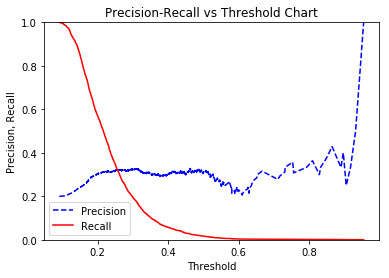

In [32]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

#Prevendo probabilidade (segunda coluna para y=1)
probs_y=logreg.predict_proba(X_val) 

#preparando o plot
precision, recall, thresholds = precision_recall_curve(y_val, probs_y[:, 
1])  
pr_auc = metrics.auc(recall, precision)

#plotando
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], color='r',label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Conseguimos ver pelo gráfico acima que conseguimos tanto aumentar a precisão quanto o *recall* se diminuirmos o ponto de corte para para 0,26 e é o que faremos:

In [33]:
corte=.26

#Calculando as probabilidades
probs_y=logreg.predict_proba(X_test)

#predizendo com novo corte
y_pred[probs_y[:,1]>=corte]=1
y_pred[probs_y[:,1]<corte]=0

#matriz de confusão 
confusion_matrix(y_pred,y_test)

array([[7425, 1468],
       [1382,  758]])

Checando índices:

In [34]:
precision=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[1,0])
recall=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[0,1])
acuracia=np.mean(y_pred==y_test)

print("A precisão é", precision, ", o recall é",recall, "e a acurácia é", acuracia)

A precisão é 0.3542056074766355 , o recall é 0.34052111410601976 e a acurácia é 0.7416840387927127


Como conseguimos aumentar os nossos dois índices, chegamos e uma situação melhor que a inicial se o nosso objetivo é encontrar as pessoas que irão faltar em consultas futuras. Uma alternativa para aumentar o desempenho do nosso modelo em fazer previsões é utilizar as variáveis de vizinhança, pois o lugar onde a consulta foi marcada pode agregar muitas informações importantes e que ainda não foram incluídas em nossa análise:

In [35]:
X=data[['WaitTime', 'Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab']]
X=X.join(data.iloc[:,25:105])

y=data["NoShow"]

Excluímos a variável 'Aeroporto' (que é um dos bairros da cidade), pois tendo todas as outras, esta se torna redundante. Poderíamos também incluir a variável que indica 'missing' para o dia da semana, mas já sabemos que é muito difícil ter essa variável faltante. Vemos que temos um grande número de variáveis neste momento e esse fato pode nos dar dor de cabeça por dois motivos principais:

1. Torna o processo de aprendizado mais demorado;
2. Pode causar um ajuste artificial na base de treino, comprometendo a generalização (overfitting);

Para contornar esse possível problema, vamos utilizar uma técnica de redução de dimensionalidade chamada Análise de Componentes Principais (PCA). Esta técnica busca representar quase a totalidade da informação presente na base de dados com um número menor de variáveis. Mas como funciona? Você concorda que se há correlações entre nossas variáveis, há certo grau de redundância, pois saber o comportamento de um conjunto de variáveis pode já me dizer o comportamento de outra variável? Esta técnica busca uma forma ótima de representar as variáveis originais de forma a captar o máximo de variação possível em um número menor de dimensões, criando novas variáveis que não estão correlacionadas:

In [36]:
Image(url= "p6.jpeg", width=600, height=300)

Adaptado: https://cdn-images-1.medium.com/max/2600/1*V3JWBvxB92Uo116Bpxa3Tw.png

Na imagem acima é possível ver que as variável X e Y são fortemente correlacionadas, então a técnica PCA constrói duas novas variáveis que são capazes de captar toda a informação inicial com o uso dos componentes principais (o PC1 e o PC2). Ademais, é possível perceber que o PC1 capta quase toda a variação dos dados por si só, então poderíamos manter somente o PC1 sem muita perda da informação original. Veja que se temos $k$ variáveis em nossa base, o método cria novas $k$ variáveis e devemos escolher os primeiros $p$ componentes (mais importantes em reter informações), sendo que $p<k$.

Nesse momento temos muitas variáveis em nossa base de dados e, apesar de as variáveis de vizinhança não estarem correlacionadas entre si, pode ser que estas estejam correlacionadas com as variáveis já existentes na base em um momento anterior. Para aplicar o método, é necessário fazer a divisão da base entre treino, validação e teste, além de padronizar todas as variáveis para terem média zero e desvio-padrão 1 (a padronização geralmente ajuda o PCA a conseguir melhores resultados).

Excluindo observações que tenham pelo menos uma das variáveis missing:

In [37]:
indices = np.where(np.isnan(X))[0]

X=X.drop(X.index[indices])
y=y.drop(y.index[indices])

Dividindo a base:

In [38]:
from sklearn.model_selection import train_test_split

train=0.8
val=.1
test=1-train-val


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test+val, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test/(val+test), random_state=99)

print(np.shape(X_train), np.shape(X_test), np.shape(X_val))
print(np.shape(y_train), np.shape(y_test), np.shape(y_val))

(88257, 94) (11033, 94) (11032, 94)
(88257,) (11033,) (11032,)


Padronizando:

In [39]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
scaler2.fit(X_train) #dando o fit na base de treino

#transformando
X_train=scaler2.transform(X_train) 
X_test=scaler2.transform(X_test)
X_val=scaler2.transform(X_val)

Para aplicar o PCA, vamos utilizar a biblioteca Scikit-Learn. **Lembre-se de sempre estimar o modelo na base de treino e depois aplicá-lo nas três bases, assim como na normalização:**

In [40]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)                 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Agora que temos o resultado do PCA, quando componentes vamos escolher para manter em nossa base? Isso depende do quanto da informação (variação) original queremos manter. Vamos análisar um gráfico que nos diz o quanto da informação original está sendo mantida em função do número de componentes:

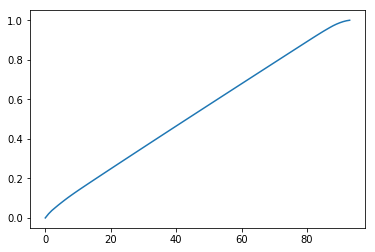

In [41]:
variance=[]

n=np.shape(pca.explained_variance_ratio_)[0]

for i in range(n):
    variance.append(np.sum(pca.explained_variance_ratio_[:i]))
    
plt.plot(variance) 
plt.show()

É possível ver que a variância está distribuída mais ou menos de forma linear entre os fatores e isso nos dá uma pista que não é bom utilizar redução de dimensionalidade nesse caso!!! Vamos selecionar os 10 primeiros componentes para você ver que vamos perder muita informação:

In [42]:
pca10 = PCA(n_components=10)
pca10.fit(X_train) 

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Aplicando a transformação nas nossas bases:

In [43]:
X_train=pca10.transform(X_train)
X_val=pca10.transform(X_val)          
X_test=pca10.transform(X_test)          

Vamos estimar novamente um modelo de regressão logística:

In [44]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logregFit = logreg.fit(X_train, y_train)

Agora vamos avaliar o gráfico de precisão e recall em função do ponto de corte:

(0, 1)

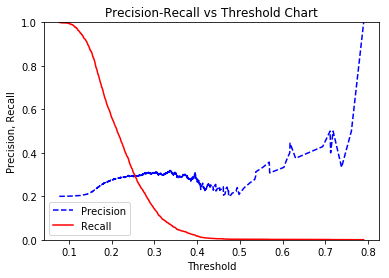

In [45]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

#Prevendo probabilidade (segunda coluna para y=1)
probs_y=logreg.predict_proba(X_val) 

#preparando o plot
precision, recall, thresholds = precision_recall_curve(y_val, probs_y[:, 
1])  
pr_auc = metrics.auc(recall, precision)

#plotando
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], color='r', label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [46]:
corte=.26

#Calculando as probabilidades
probs_y=logreg.predict_proba(X_test)

#predizendo com novo corte
y_pred[probs_y[:,1]>=corte]=1
y_pred[probs_y[:,1]<corte]=0

#Resultados
precision=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[1,0])
recall=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[0,1])
acuracia=np.mean(y_pred==y_test)

print("A precisão é", precision, ", o recall é",recall, "e a acurácia é", acuracia)

A precisão é 0.328921568627451 , o recall é 0.30143755615453727 e a acurácia é 0.7349768875192604


É possível ver que, apesar de termos incluído mais informações na análise, o resultado final pouco mudou, apesar de termos tido uma pequena elevação no recall. Talvez fosse melhor não inlcuir as variáveis de vizinhança em nossa análise, pois sempre é bom optar por modelos mais simples se o resultado é parecido. No entanto, vamos continuar com nossas variáveis transformadas pelo PCA e partir para o uso de uma rede neural, buscando melhor performance, que pode ocorrer ou não. 

**Rede Neural**

Vamos começar estimando uma rede neural com 100 neurônios na camada oculta, trocando a medida de erro do EQM para o *binary cross-entropy* e a função de ativação da camada de saída de linear para sigmoid, pois nossa variável de interesse é qualitativa e binária:

In [47]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras import optimizers

Using TensorFlow backend.


In [ ]:
k=100 #número de neurônios ocultos

input_data = Input(shape=(np.shape(X_train)[1],))
hidden = Dense(k, activation='relu')(input_data)
output = Dense(1, activation='sigmoid')(hidden)


#criando modelo
classifier = Model(input_data, output)

#Fitting
classifier.compile(optimizer='adam', loss='binary_crossentropy')

modelo=classifier.fit(X_train, y_train,
                      epochs=200,
                      batch_size=1000,
                      shuffle=True,
                      validation_data=(X_val, y_val))

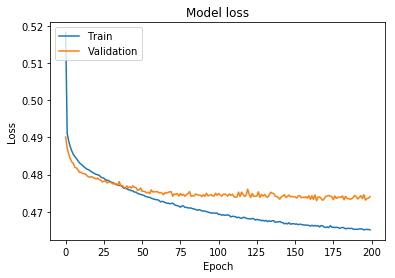

In [49]:
#Plotando dados de treino
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Vamos fazer um outro teste, mantendo somente as variáveis originais, inclusive as que são de vizinhança:

In [65]:
X=data[['WaitTime', 'Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab']]
X=X.join(data.iloc[:,25:105])
y=data["NoShow"]
indices = np.where(np.isnan(X))[0]

X=X.drop(X.index[indices])
y=y.drop(y.index[indices])

Dividindo:

In [66]:
from sklearn.model_selection import train_test_split

train=0.8
val=.1
test=1-train-val


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test+val, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test/(val+test), random_state=99)

print(np.shape(X_train), np.shape(X_test), np.shape(X_val))
print(np.shape(y_train), np.shape(y_test), np.shape(y_val))

(88257, 94) (11033, 94) (11032, 94)
(88257,) (11033,) (11032,)


Normalizando:

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train) #dando o fit na base de treino

#transformando
X_train=scaler.transform(X_train) 
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)

Treinando rede neural:

In [ ]:
k=100 #número de neurônios ocultos

input_data = Input(shape=(np.shape(X_train)[1],))
hidden = Dense(k, activation='relu')(input_data)
output = Dense(1, activation='sigmoid')(hidden)


#criando modelo
classifier = Model(input_data, output)

#Fitting
classifier.compile(optimizer='adam', loss='binary_crossentropy')
                   
modelo=classifier.fit(X_train, y_train,
                      epochs=200,
                      batch_size=1000,
                      shuffle=True,
                      validation_data=(X_val, y_val))

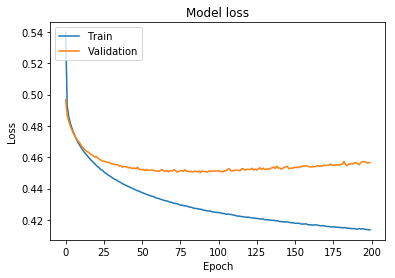

In [69]:
#Plotando dados de treino
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Vamos fazer um outro teste, mantendo somente as variáveis originais, tirando as que são de vizinhança:

In [70]:
X=data[['WaitTime', 'Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab']]
y=data["NoShow"]
indices = np.where(np.isnan(X))[0]

X=X.drop(X.index[indices])
y=y.drop(y.index[indices])

Dividindo:

In [71]:
from sklearn.model_selection import train_test_split

train=0.8
val=.1
test=1-train-val


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test+val, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test/(val+test), random_state=99)

print(np.shape(X_train), np.shape(X_test), np.shape(X_val))
print(np.shape(y_train), np.shape(y_test), np.shape(y_val))

(88257, 14) (11033, 14) (11032, 14)
(88257,) (11033,) (11032,)


Normalizando:

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train) #dando o fit na base de treino

#transformando
X_train=scaler.transform(X_train) 
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)

Treinando rede neural:

In [ ]:
k=100 #número de neurônios ocultos

input_data = Input(shape=(np.shape(X_train)[1],))
hidden = Dense(k, activation='relu')(input_data)
output = Dense(1, activation='sigmoid')(hidden)


#criando modelo
classifier = Model(input_data, output)

#Fitting
classifier.compile(optimizer='adam', loss='binary_crossentropy')

modelo=classifier.fit(X_train, y_train,
                      epochs=200,
                      batch_size=1000,
                      shuffle=True,
                      validation_data=(X_val, y_val))

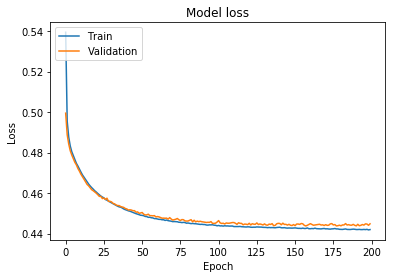

In [74]:
#Plotando dados de treino
plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

É possível ver que o resultado já foi bem otimizado quando não utilizamos aquelas variáveis de vizinhança. Isso pode ter ocorrido por um problema de "overfitting", por exemplo. Agora vamos dar uma olhada nas nossa métricas para avaliar nosso modelo:

(0, 1)

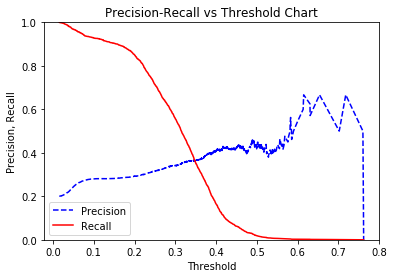

In [75]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

#Prevendo probabilidade (segunda coluna para y=1)
probs_y=classifier.predict(X_val) 

#preparando o plot
precision, recall, thresholds = precision_recall_curve(y_val, probs_y)  
pr_auc = metrics.auc(recall, precision)

#plotando
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], color='r', label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Olhando para o gráfico acima, temos que definir um ponto de corte para então realizar a classificação. Lembre-se que o ponto de corte depende muito do seu problema e de seus objetivos. Aqui vamos utilizar um ponto de 0.2 como exemplo:

In [76]:
corte=.32

#Calculando as probabilidades
probs_y=classifier.predict(X_test) 
probs_y=np.reshape(probs_y,-1) 

#predizendo com novo corte
y_pred=np.zeros(np.shape(y_test))
y_pred[probs_y>=corte]=1

#Resultados
precision=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[1,0])
recall=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[0,1])
acuracia=np.mean(y_pred==y_test)

print("A precisão é", precision, ", o recall é",recall, "e a acurácia é", acuracia)

A precisão é 0.3653271338425772 , o recall é 0.4941599281221923 e a acurácia é 0.7247348862503399


Assim como fizemos na parte de regressão, vamos realizar o procedimento de ajuste dos hiperparâmetros (validação), que nesse caso são o número de neurônios na camada oculta e a taxa de dropout utilizada no treinamento. Vamos utilizar o método da busca aleatória, ou seja, vamos fazer algumas simulações aleatórias e escolher o melhor par de hiperparâmetros (aquele que miniza o erro):

In [77]:
#definindo intervalo de # neurônios
interval_neur=list(range(100,500))
#definindo intervalo de % dropout
interval_drop=[0,.2]

#Número de iterações
N=10

#Fixando semente para replicabilidade
np.random.seed(42)

Processo de aprendizado:

In [ ]:
#Processo de validação 
from keras.layers import Dropout

for i in range(N):
    
    #sorteando par
    neur=np.random.choice(interval_neur)
    drop=float(np.random.uniform(interval_drop[0],interval_drop[1],1)) 
    
    input_data = Input(shape=(np.shape(X_train)[1],))
    Drop=Dropout(drop)(input_data)
    hidden = Dense(neur, activation='relu')(Drop)
    output = Dense(1, activation='sigmoid')(hidden)


    #criando modelo
    classifier = Model(input_data, output)

    #Fitting
    classifier.compile(optimizer='adam', loss='binary_crossentropy')

    modelo=classifier.fit(X_train, y_train,
                          epochs=200,
                          batch_size=1000,
                          shuffle=True,
                          validation_data=(X_val, y_val))

    #Avaliando na base de validação
    score = classifier.evaluate(X_val, y_val, verbose=0)
    
    #Definindo o melhor par de hiperparâmetros até o momento, 
    #guardando melhor score e melhor modelo
    if i==0:
        melhor_par=[neur,drop]
        melhor_score=score
        melhor_modelo=classifier
    
    elif score>melhor_score:
        melhor_par=[neur,drop]
        melhor_score=score
        melhor_modelo=classifier

Agora que já temos calculados os hiperparâmetros ótimos - veja que para se ter um resultado mais confiável, é preciso iterar muitas vezes e só não o fiz por falta de tempo e de poder computacional. Vamos ver qual o melhor par de hiperparâmetros:

In [79]:
melhor_par, melhor_score

([294, 0.16297846834058816], 0.45531715793052907)

Vemos que apesar de fazer 10 buscas diferentes, não conseguimos achar um modelo melhor do que aquele inicial e isso se deu provavelmente por conta de um *undefit*, devido ao dropout (10 não é grande coisa também). Agora que temos o melhor par e o modelo já foi treinado, vamos só salvar o nosso modelo (pesos aprendidos) no disco, o que é muito útil, pois não precisamos realizar o treinamento toda vez que utilizamos o modelo para fazer previsões. Vamos salvá-lo:

In [80]:
melhor_modelo.save("melhor_modelo.h5")

Agora que o salvamos, vamos reabrí-lo só para você ver como funciona:

In [81]:
modelo_carregado=load_model("melhor_modelo.h5")

Agora que reabrimos nosso modelo, vamos prever se as pessoas que estão na base de teste foram ou não à consulta:

In [83]:
probs_y=classifier.predict(X_test)

#predizendo
corte=.2
y_pred=np.zeros(np.shape(y_test))
y_pred[(probs_y>=corte)[:,0]]=1

Resta somente fazer a avaliação do modelo na base de teste, com base na acurácia, recall e precisão:

In [84]:
#Resultados
precision=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[1,0])
recall=confusion_matrix(y_pred,y_test)[1,1]/(confusion_matrix(y_pred,y_test)[1,1]+confusion_matrix(y_pred,y_test)[0,1])
acuracia=np.mean(y_pred==y_test)

print("A precisão é", precision, ", o recall é",recall, "e a acurácia é", acuracia)

A precisão é 0.29667480170835875 , o recall é 0.8737646001796945 e a acurácia é 0.5566029185171757


Matriz de confusão:

In [85]:
confusion_matrix(y_pred,y_test)

array([[4196,  281],
       [4611, 1945]])